# Classifying Images with a Vision Transformer


In [ ]:
!pip install deeplay 

## **Using the CIFAR-10 Dataset**

For this task I chose to use CIFAR-10 Dataset.

Comprising 60,000 images, each 32x32 pixels and in full color, CIFAR-10 is categorized into 10 distinct classes, with each class containing 6,000 images. The dataset is divided into a training set of 50,000 images and a testing set of 10,000 images.

Download and prepare the data ...

In [2]:
from torchvision import datasets

train_val_dataset = datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Implement a function to visualize the first CIFAR-10 images for each class

In [3]:
import matplotlib.pyplot as plt

def plot_class_examples(dataset, n_images):
    """Plot the first images for each class in the dataset."""
    classes = dataset.classes
    class_img_dict = {c: [] for c in range(len(classes))}
    for i, (_, label) in enumerate(dataset):
        if all(len(v) == n_images for v in class_img_dict.values()):
            break
        if len(class_img_dict[label]) < n_images:
            class_img_dict[label].append(i)

    fig, axs = plt.subplots(n_images, len(classes), figsize=(len(classes), 3))
    for class_idx, img_indices in class_img_dict.items():
        for j, img_index in enumerate(img_indices):
            img = dataset[img_index][0]
            axs[j, class_idx].imshow(img)
            axs[j, class_idx].set(xticks=[], yticks=[])
            if j == 0:
                axs[j, class_idx].set_title(classes[class_idx], size="medium")
    plt.show()

Visualize the first CIFAR-10 images for each class.

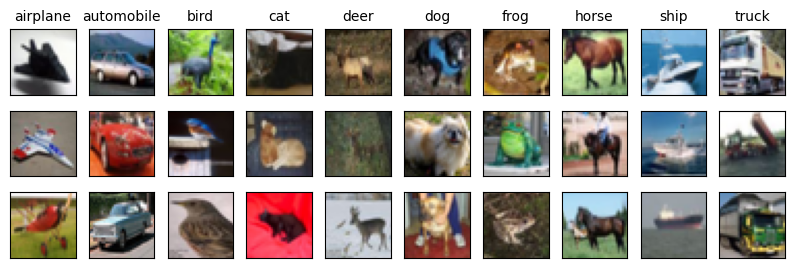

In [4]:
plot_class_examples(train_val_dataset, n_images=3)

### Preprocessing the data

Split the trainign and validation datasets

In [5]:
import copy, torch
from torch.utils.data import Subset

indices = torch.randperm(len(train_val_dataset)).tolist()
split = int(len(train_val_dataset) * 0.20)
train_indices, val_indices = indices[split:], indices[:split]
train_dataset = Subset(copy.deepcopy(train_val_dataset), train_indices)
val_dataset = Subset(copy.deepcopy(train_val_dataset), val_indices)

Ddd transformations to preprocess the training dataset

In [6]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091],
                         std=[0.24703223, 0.24348513, 0.26158784]),
])
train_dataset.dataset.transform = train_transform

Do the same for the validation dataset

In [7]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091],
                         std=[0.24703223, 0.24348513, 0.26158784]),
])
val_dataset.dataset.transform = val_transform

Define the data loaders

In [8]:
import deeplay as dl

train_loader = dl.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = dl.DataLoader(val_dataset, batch_size=128, shuffle=False)

## Building the ViT Model

Instantiate the ViT model

In [9]:
vit = dl.ViT(in_channels=3, image_size=32, patch_size=4,
             hidden_features=[384,] * 7, out_features=10, num_heads=12)

Print out its architecture.

In [10]:
print(vit)

ViT(
  (patch_embedder): Patchify(
    (layer): Layer[Conv2d](in_channels=3, out_channels=384, kernel_size=4, stride=4)
    (dropout): Layer[Dropout](p=0)
  )
  (positional_embedder): PositionalEmbedding(
    (dropout): Layer[Dropout](p=0)
  )
  (transformer_encoder): TransformerEncoderLayer(
    (blocks): LayerList(
      (0-6): 7 x SequentialBlock(
        (multihead): LayerDropoutSkipNormalization(
          (normalization): Layer[LayerNorm](normalized_shape=384)
          (layer): MultiheadSelfAttention(
            (projection): Layer[Identity]()
            (attention): Layer[MultiheadAttention](embed_dim=384, num_heads=12, batch_first=True)
          )
          (dropout): Layer[Dropout](p=0)
          (skip): Add()
        )
        (feed_forward): LayerDropoutSkipNormalization(
          (normalization): Layer[LayerNorm](normalized_shape=384)
          (layer): MultiLayerPerceptron(
            (blocks): LayerList(
              (0-1): 2 x LinearBlock(
                (layer):

## Training and Evaluating the ViT

Define the classifier

In [11]:
classifier = dl.Classifier(
    model=vit, num_classes=10,
    optimizer=dl.Adam(lr=1e-3, weight_decay=5e-5, betas=(0.9, 0.999)),
).build()

Train the model

In [ ]:
trainer = dl.Trainer(max_epochs=100)
trainer.fit(classifier, train_loader, val_loader)
trainer.history.plot();

And evaluate it on the test set.

In [ ]:
test_dataset.transform = val_transform
test_loader = dl.DataLoader(test_dataset, batch_size=128, shuffle=False)

trainer.test(classifier, test_loader)

## Improving the ViT Model with CutMix

Implement a class to perform the CutMix

In [14]:
import numpy as np

class CutMix():
    """CutMix."""

    def __init__(self, size, beta):
        """Initialize CutMix."""
        self.size, self.beta = size, beta

    def __call__(self, batch):
        """Execute CutMix."""
        imgs, labels = batch
        rand_idx  = torch.randperm(imgs.size(0))
        rand_imgs, rand_labels = imgs[rand_idx], labels[rand_idx]
        augmented_imgs = imgs.clone()

        r_x = np.random.uniform(0, self.size)
        r_y = np.random.uniform(0, self.size)

        initial_mix_ratio = np.random.beta(self.beta, self.beta)
        r_w = self.size * np.sqrt(1 - initial_mix_ratio)
        r_h = self.size * np.sqrt(1 - initial_mix_ratio)

        x1 = np.clip(int(r_x - r_w // 2), a_min=0, a_max=self.size)
        x2 = np.clip(int(r_x + r_w // 2), a_min=0, a_max=self.size)
        y1 = np.clip(int(r_y - r_h // 2), a_min=0, a_max=self.size)
        y2 = np.clip(int(r_y + r_h // 2), a_min=0, a_max=self.size)

        augmented_imgs[:, :, y1:y2, x1:x2] = rand_imgs[:, :, y1:y2, x1:x2]
        final_mix_ratio = 1 - ((x2 - x1) * (y2 - y1) / (self.size ** 2))
        return augmented_imgs, labels, rand_labels, final_mix_ratio

Visualize an example of CutMix augmentation

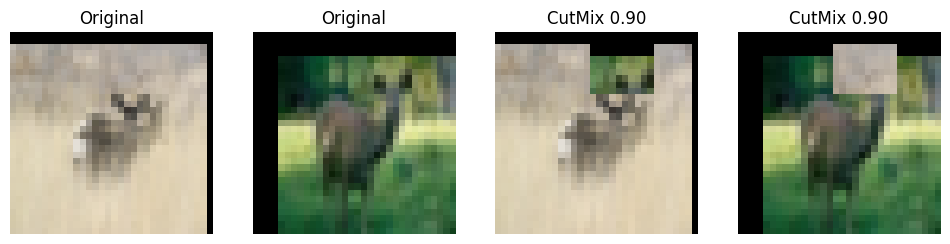

In [15]:
import random
from itertools import chain

def create_batch(samples):
    """Create batch."""
    images, labels = zip(*samples)
    return torch.stack(images), torch.tensor(labels)

def normalize_image(image):
    """Normalize image."""
    mean = torch.tensor([0.49139968, 0.48215841, 0.44653091]).view(3, 1, 1)
    std = torch.tensor([0.24703223, 0.24348513, 0.26158784]).view(3, 1, 1)
    return image * std + mean

samples = random.choices(train_dataset, k=2)
batch = create_batch(samples)

augmented_imgs, *_, mix_ratio = CutMix(size=32, beta=1.0)(batch)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, img in enumerate(chain(batch[0], augmented_imgs)):
    axs[i].imshow(normalize_image(img).permute(1, 2, 0))
    axs[i].set_title("Original" if i < 2 else f"CutMix {mix_ratio:.2f}")
    axs[i].axis("off")
plt.show()

Implement a classifier that makes use of CutMix

In [16]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler as GradualWarmup

class CutMixClassifier(dl.Classifier):
    """Classifier with CutMix."""

    def __init__(self, model, size=32, beta=1.0, **kwargs):
        """Initialize classifier with CutMix."""
        super().__init__(model, **kwargs)
        self.cutmix = CutMix(size=size, beta=beta)

    def training_step(self, batch, batch_idx):
        """Perform one training step."""
        augmented_imgs, labels, rand_labels, mix_ratio = self.cutmix(batch)
        pred_labels = self.model(augmented_imgs)
        loss = (mix_ratio * self.loss(pred_labels, labels)
                + (1 - mix_ratio) * self.loss(pred_labels, rand_labels))

        self.log("train_loss", loss, on_step=True, on_epoch=True,
                 prog_bar=True, logger=True)
        self.log_metrics("train", pred_labels, labels, on_step=True,
                         on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        """Configure optimizers."""
        optimizer = super().configure_optimizers()
        base_scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-5)
        scheduler = GradualWarmup(optimizer, multiplier=1.0, total_epoch=5,
                                  after_scheduler=base_scheduler)
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}

Train the ViT model with CutMix

In [ ]:
vit_cutmix = dl.ViT(in_channels=3, image_size=32, patch_size=4,
                    hidden_features=[384,] * 7, out_features=10, num_heads=12)
vit_cutmix[..., "attention#-1"].log_output("attention_output")

classifier_cutmix = CutMixClassifier(
    model=vit_cutmix, num_classes=10,
    optimizer=dl.Adam(lr=1e-3, weight_decay=5e-5, betas=(0.9, 0.999)),
).build()
trainer_cutmix = dl.Trainer(max_epochs=700)
trainer_cutmix.fit(classifier_cutmix, train_loader, val_loader)

Test the ViT trained with CutMix

In [18]:
trainer_cutmix.test(classifier_cutmix, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.8529999852180481      │
│       test_loss_epoch        │      0.4775465428829193      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.4775465428829193,
  'testMulticlassAccuracy_epoch': 0.8529999852180481}]

Check the logs.

In [19]:
print(classifier_cutmix.logs)

{'attention_output': (tensor([[[-6.1548e-02, -2.9231e-01, -1.4262e-01,  ...,  7.2730e-02,
          -1.4346e-01, -5.5991e-02],
         [-1.1959e-01, -8.1969e-02, -8.4847e-01,  ..., -4.8802e-02,
          -1.4996e-01, -2.1800e-01],
         [-1.5831e-01, -2.0762e-01, -1.3626e+00,  ..., -7.5503e-02,
          -1.3523e-01, -2.7639e-01],
         ...,
         [-1.6319e-01,  5.2794e-01, -1.5871e-01,  ...,  1.3905e-01,
          -7.3576e-02, -3.4563e-02],
         [-1.9845e-01,  1.9896e-01, -8.1428e-01,  ...,  3.1877e-02,
          -1.1580e-01, -1.6664e-01],
         [-1.9214e-01, -5.3241e-02, -1.1531e+00,  ...,  9.4408e-04,
          -1.3963e-01, -2.7267e-01]],

        [[ 1.0534e-01, -1.8963e-01,  7.1094e-01,  ..., -4.0971e-02,
          -2.4626e-02,  9.6270e-02],
         [-1.0601e-01,  1.1044e-01,  4.0864e-01,  ...,  1.8366e-01,
           1.1362e-01,  1.6101e-01],
         [-1.1315e-01,  9.0502e-02,  9.7872e-01,  ...,  2.0210e-01,
           1.6124e-01,  2.1285e-01],
         ...,
   

### Visualizing Attention Maps

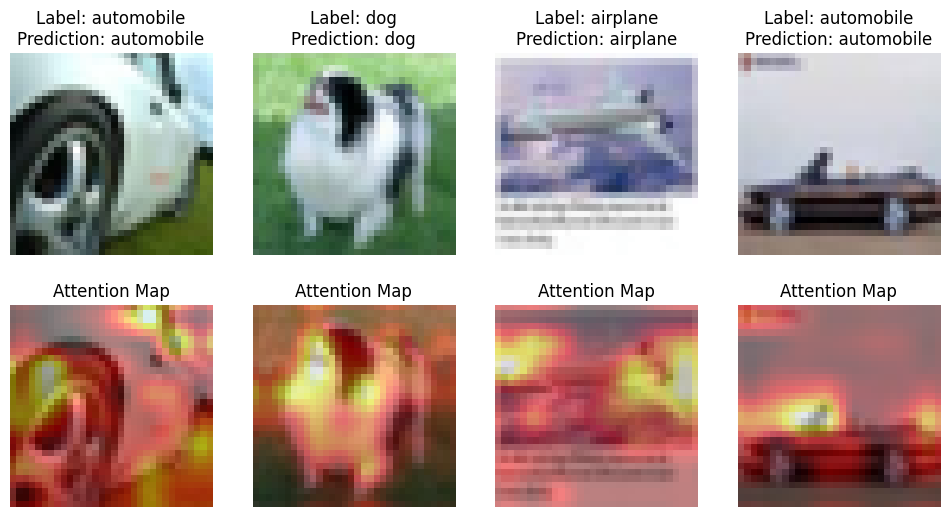

In [20]:
from skimage.transform import resize

samples = random.choices(test_dataset, k=4)
imgs, labels = create_batch(samples)

classifier_cutmix.model.eval()
output = classifier_cutmix(imgs)
preds = torch.argmax(output, dim=1)

attn_maps = \
    classifier_cutmix.logs["attention_output"][1][:, 0, 1:].reshape(4, 8, 8)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, (img, label, pred, attn_map) in enumerate(
    zip(imgs, labels, preds, attn_maps)
):
    img = normalize_image(img).detach().permute(1, 2, 0)

    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Label: {test_dataset.classes[label]}\n"
                        + f"Prediction: {test_dataset.classes[pred]}")
    axs[0, i].axis("off")

    resized_attn_map = resize(attn_map.detach().numpy(), (32, 32),
                              anti_aliasing=True)
                              
    axs[1, i].imshow(img)
    axs[1, i].imshow(resized_attn_map, cmap="hot", alpha=0.5)
    axs[1, i].set_title("Attention Map")
    axs[1, i].axis("off")
plt.show()


## Using a Pretrained ViT Model

Implement a class to use a pretrained ViT model

In [21]:
from transformers import ViTModel

class PretrainedViTModel(torch.nn.Module):
    """Pretrained ViT model."""

    def __init__(self, pretrained_model, output_channels):
        """Initialize pretrained ViT model."""
        super().__init__()
        self.backbone = ViTModel.from_pretrained(pretrained_model)
        hidden_features = self.backbone.config.hidden_size
        self.classifier = torch.nn.Linear(hidden_features, output_channels)

    def forward(self, imgs):
        """Perform forward step."""
        features = self.backbone(imgs).last_hidden_state[:, 0]
        return self.classifier(features)

Implement the preprocessing and augmentation pipelines

In [22]:
from transformers import ViTImageProcessor

pretrained_model = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(pretrained_model)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

train_transforms_pt = transforms.Compose([
    transforms.Resize((size, size)), transforms.RandomCrop(size, padding=4),
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])
val_transforms_pt = transforms.Compose([
    transforms.Resize((size, size)), transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
])

train_dataset_pt = copy.deepcopy(train_dataset)
train_dataset_pt.dataset.transform = train_transforms_pt
val_dataset_pt = copy.deepcopy(val_dataset)
val_dataset_pt.dataset.transform = val_transforms_pt
test_dataset_pt = copy.deepcopy(test_dataset)
test_dataset_pt.transform = val_transforms_pt


Redefine the data loaders

In [23]:
train_loader_pt = dl.DataLoader(train_dataset_pt, batch_size=32, shuffle=True)
val_loader_pt = dl.DataLoader(val_dataset_pt, batch_size=32, shuffle=False)
test_loader_pt = dl.DataLoader(test_dataset_pt, batch_size=32, shuffle=False)

Set up and train the classifier

In [24]:
classifier_pt = dl.Classifier(
    model=PretrainedViTModel(pretrained_model, output_channels=10),
    num_classes=10, optimizer=dl.Adam(lr=2e-5),
).build()
trainer_pt = dl.Trainer(max_epochs=2)
trainer_pt.fit(classifier_pt, train_loader_pt, val_loader_pt)


  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | loss          | CrossEntropyLoss   | 0      | train
1 | train_metrics | MetricCollection   | 0      | train
2 | val_metrics   | MetricCollection   | 0      | train
3 | test_metrics  | MetricCollection   | 0      | train
4 | model         | PretrainedViTModel | 86.4 M | train
5 | optimizer     | Adam               | 0      | train
-------------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params
345.588   Total estimated model params size (MB)
10        Modules in train mode
227       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Test it.

In [25]:
trainer_pt.test(classifier_pt, test_loader_pt)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9783999919891357      │
│       test_loss_epoch        │     0.08723384141921997      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.08723384141921997,
  'testMulticlassAccuracy_epoch': 0.9783999919891357}]